In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


import matplotlib as mpl
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import hsv_to_rgb


%matplotlib inline

In [2]:
# Import Image
def load_img():
    img = cv2.imread('/Users/garethtate/plantcv/TestImagesRPi/Still-1-RGB-2021-07-02_13-02-08.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img



In [3]:
# Display Image
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img)
    
def display_gray(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [4]:
# Global Variables

x_coords = []
y_coords = []

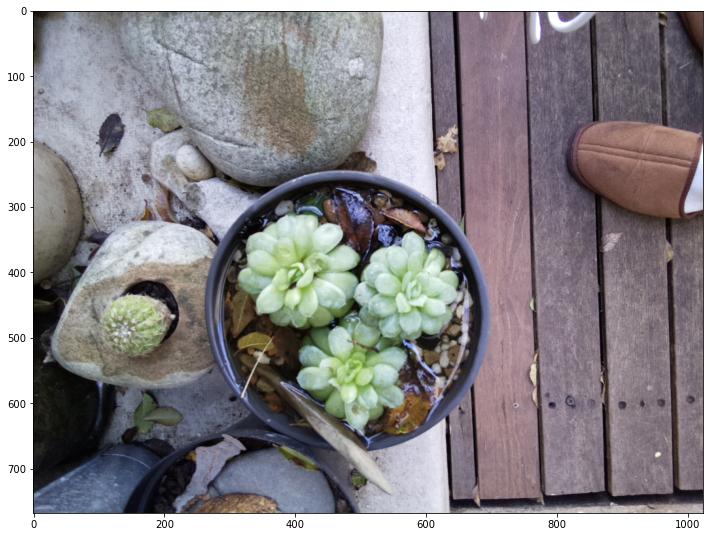

In [5]:
weed = load_img()
display_img(weed)

In [6]:
weed.shape

(768, 1024, 3)

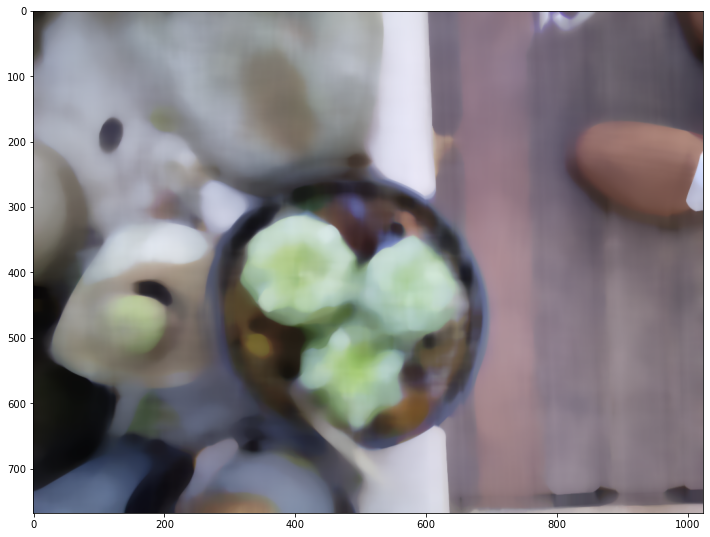

In [7]:
# Blur image
weed_blur = cv2.medianBlur(weed,35)
display_img(weed_blur)


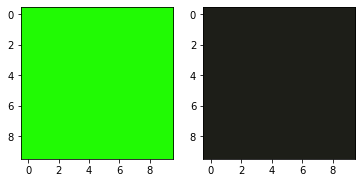

In [8]:
# Selecting a color range
hsv_weed = cv2.cvtColor(weed_blur, cv2.COLOR_RGB2HSV)

# These need to be adjusted
light_green = (45, 45, 30)
dark_green = (80, 250, 250)

# Creating color palete of range for reference
lo_square = np.full((10, 10, 3), light_green, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_green, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

In [9]:
# create a mask that searches image for colour values in range
mask = cv2.inRange(hsv_weed, light_green, dark_green)

In [10]:
# Bitwise AND the mask with the new image
result = cv2.bitwise_and(weed_blur, weed_blur, mask=mask)

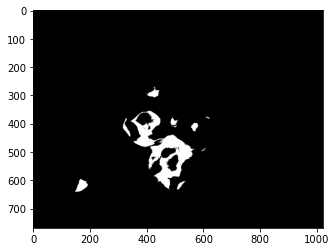

In [11]:
# Plot the result 
plt.imshow(mask, cmap="gray")

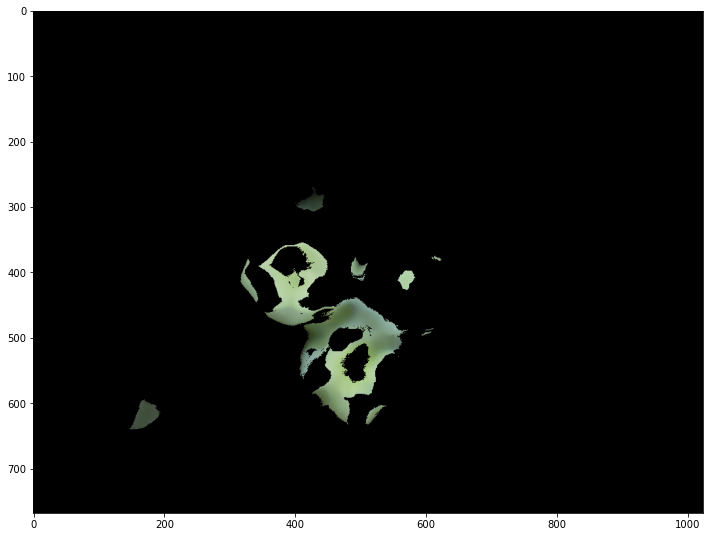

In [12]:
display_img(result)

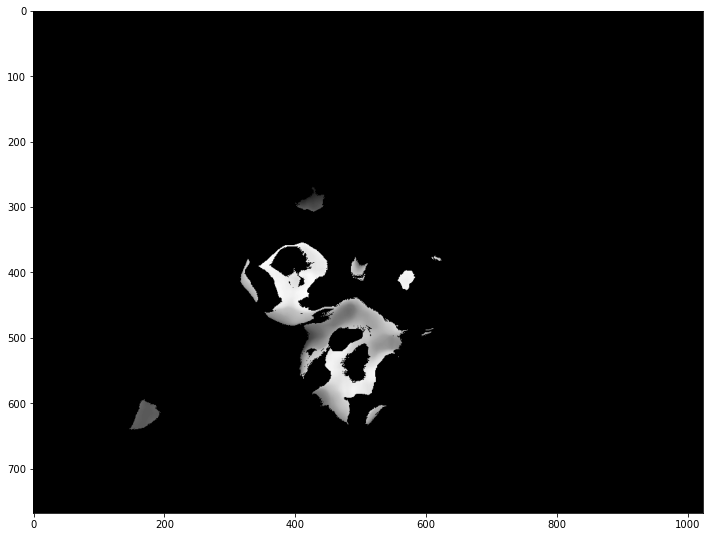

In [13]:
# WATERSHED ALGORITHM
gray_image = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
display_gray(gray_image)

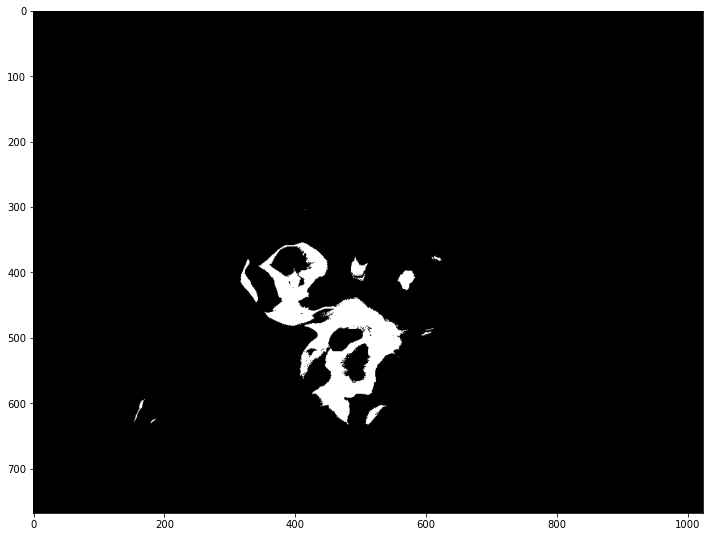

In [14]:
ret, thresh = cv2.threshold(gray_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
display_gray(thresh)

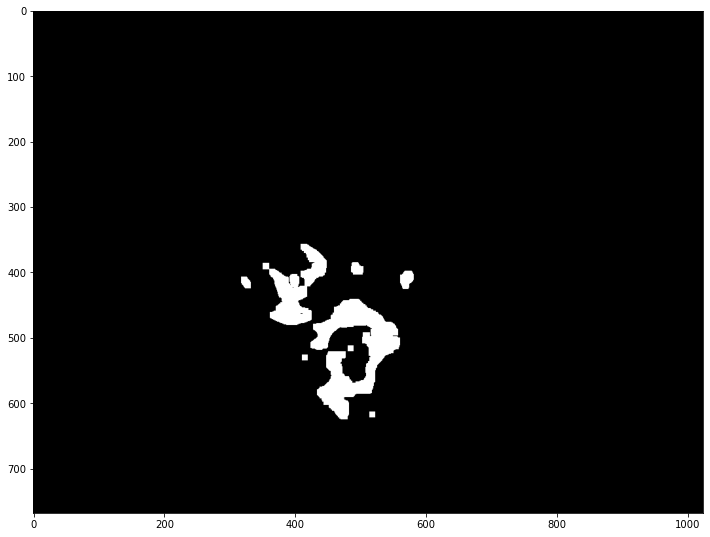

In [15]:
# noise removal
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
display_gray(opening)

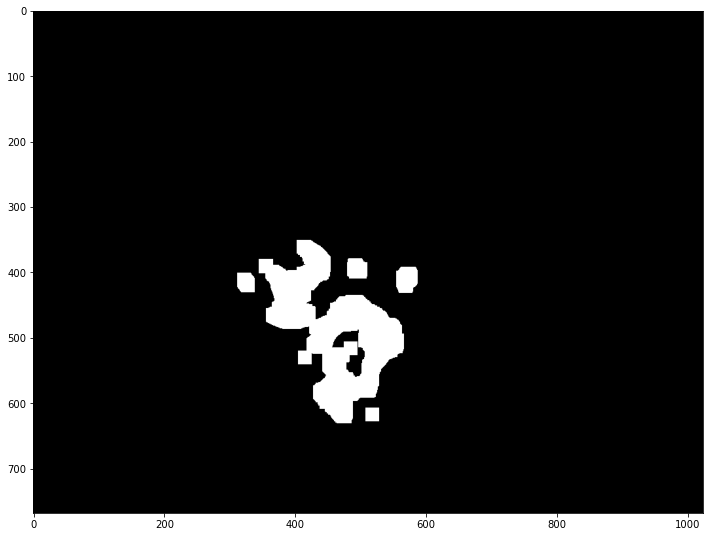

In [16]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
display_gray(sure_bg)

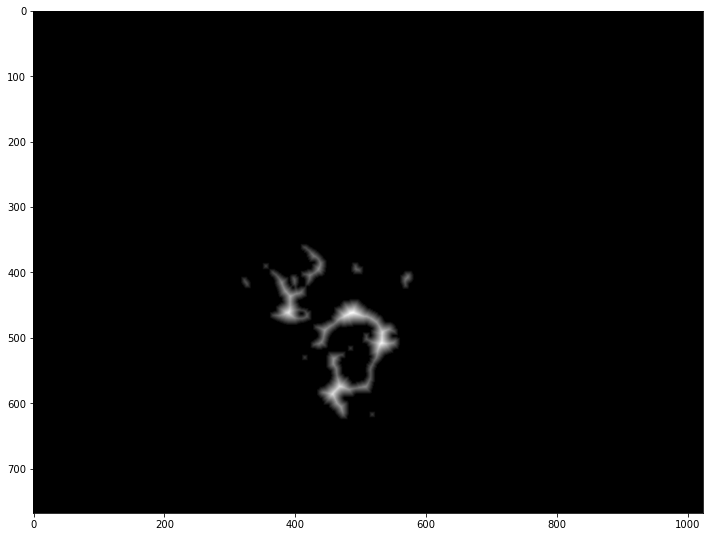

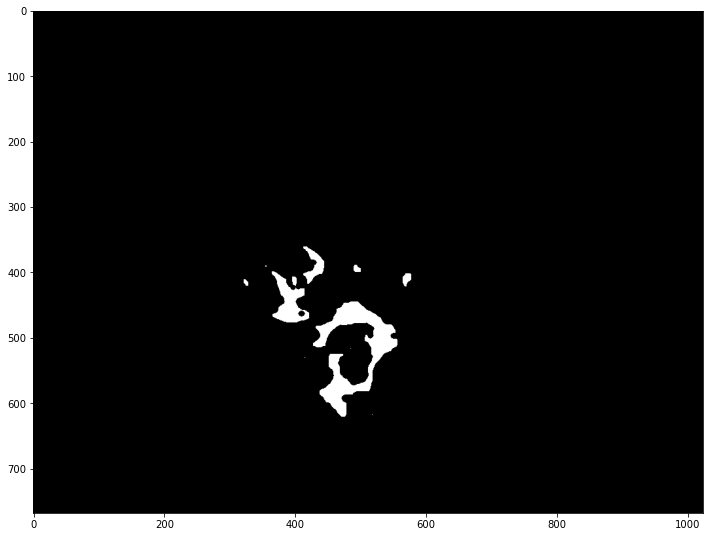

In [17]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
display_gray(dist_transform)
display_gray(sure_fg)

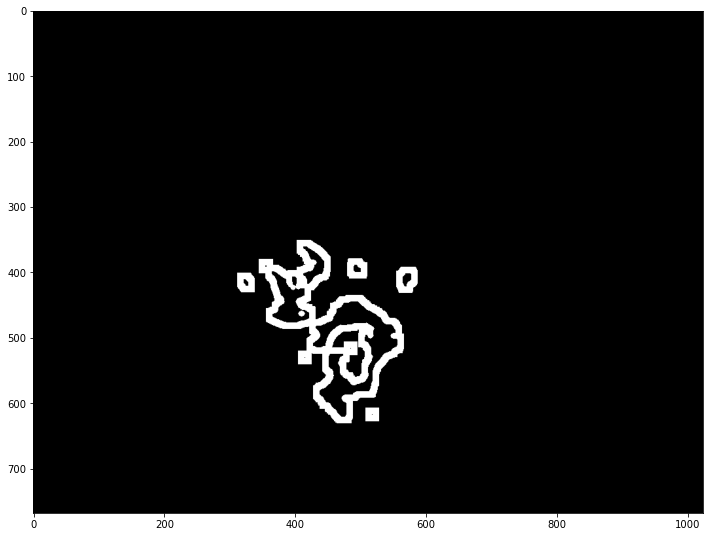

In [18]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
display_gray(unknown)

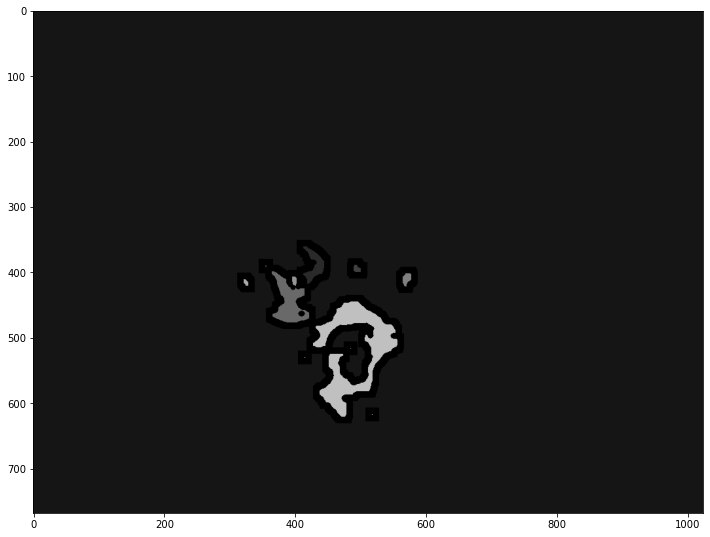

In [19]:
# Marker labelling
marker_count, markers = cv2.connectedComponents(sure_fg) # ret = number of regions
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
display_gray(markers)

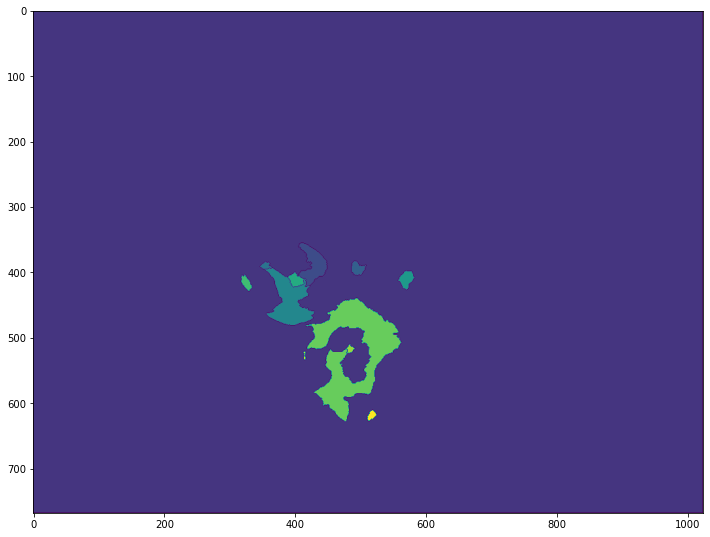

In [20]:
segmented = cv2.watershed(result,markers)
display_img(markers)

Label 2 at (406, 356) size (43 x 66) area 1405 pixels
Label 3 at (487, 383) size (22 x 22) area 299 pixels
Label 4 at (347, 384) size (18 x 12) area 114 pixels
Label 5 at (355, 394) size (75 x 87) area 3172 pixels
Label 6 at (558, 398) size (25 x 29) area 404 pixels
Label 7 at (390, 400) size (24 x 23) area 317 pixels
Label 8 at (318, 404) size (17 x 25) area 223 pixels
Label 9 at (417, 440) size (146 x 188) area 10394 pixels
Label 10 at (479, 510) size (13 x 14) area 94 pixels
Label 11 at (413, 521) size (4 x 13) area 24 pixels
Label 12 at (511, 611) size (14 x 16) area 133 pixels


/Users/garethtate/opt/anaconda3/envs/plantcv/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 255 + 1) instead
  if sys.path[0] == '':


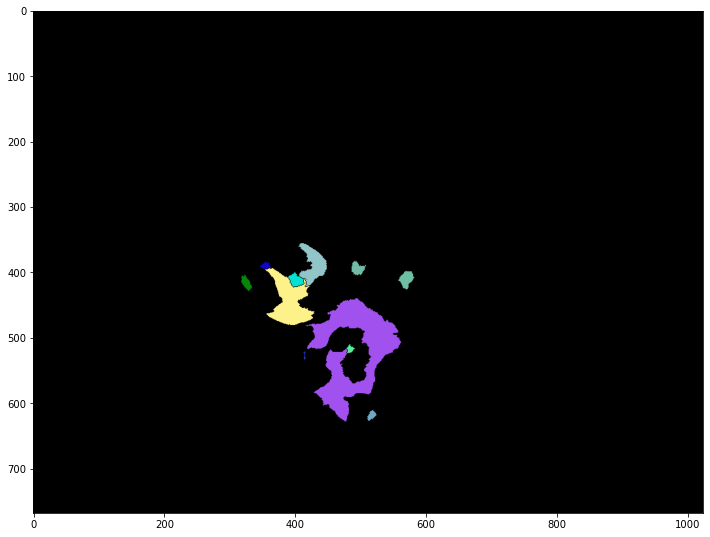

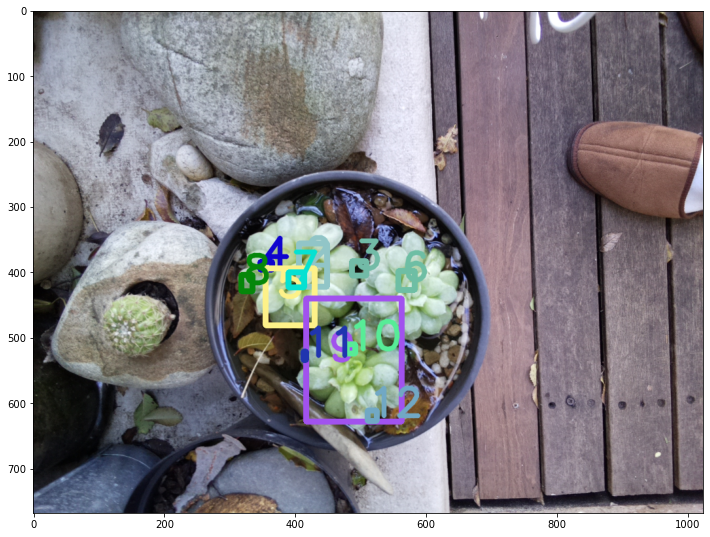

In [21]:
output = np.zeros_like(weed)
output2 = weed.copy()

# Iterate over all non-background labels
for i in range(2, marker_count + 1):
    mask = np.where(segmented==i, np.uint8(255), np.uint8(0))
    x,y,w,h = cv2.boundingRect(mask)
    area = cv2.countNonZero(mask[y:y+h,x:x+w])
    print("Label {} at ({}, {}) size ({} x {}) area {} pixels".format(i,x,y,w,h,area))

    # Visualize
    color = np.uint8(np.random.random_integers(0, 255, 3)).tolist()
    output[mask!=0] = color
    cv2.rectangle(output2, (x,y), (x+w,y+h), color, 8)
    x = int(x+w/4)
    y = int(y+h/2)
    cv2.putText(output2,"{}".format(i),(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 6, cv2.LINE_AA)
    
    # Add coordinates to x and y lists
    x_coords.append(x)
    y_coords.append(y)
    


display_img(output)
display_img(output2)

In [22]:
x_coords
y_coords



[389, 394, 390, 437, 412, 411, 416, 534, 517, 527, 619]

In [23]:
x_coordsntours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(weed, contours, i, (255, 0, 0), 10)
display_img(weed)

ValueError: too many values to unpack (expected 2)

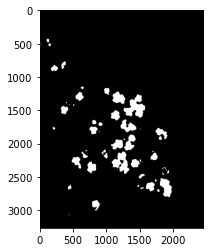

In [23]:
ret1,thresh1 = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)
plt.imshow(thresh1,cmap='gray')

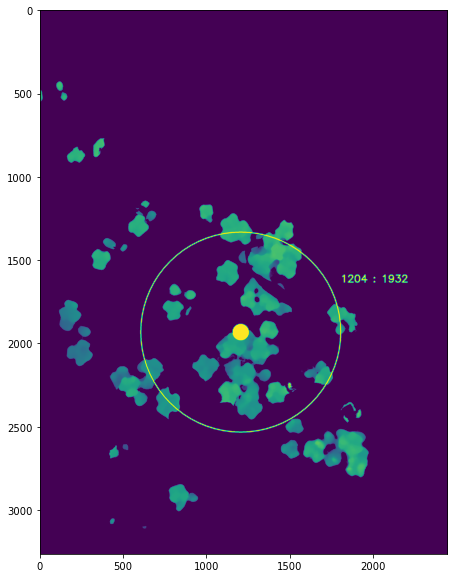

In [24]:
# calculate moments of binary image
M = cv2.moments(thresh1)
 
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

# put text and highlight the center

# write function for placement of coordinates
font = cv2.FONT_HERSHEY_SIMPLEX
gray_image = cv2.circle(img=gray_image, center=(cX,cY), radius=50, color=(255,0,0), thickness=-1)


gray_image = cv2.circle(img=gray_image, center=(cX,cY), radius=600, color=(255,0,0), thickness=5)
cv2.putText(gray_image, "{} : {}".format(cX, cY), (cX + 600, cY - 300),fontFace=font,fontScale= 2,color=(255,255,255),thickness=6,lineType=cv2.LINE_AA)

# display the image
display_img(gray_image)

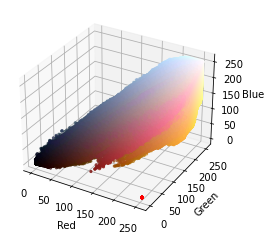

In [25]:
# View colour layout on 3D axes

# On RGB colour scheme

r, g, b = cv2.split(weed)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = weed.reshape((np.shape(weed)[0]*np.shape(weed)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

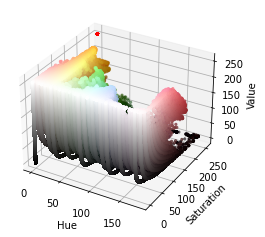

In [26]:
# Lets convert into the HSV colour space

hsv_weed = cv2.cvtColor(weed, cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_weed)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()